In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    TextVectorization, 
    Embedding, 
    Dense, 
    Dropout, 
    Bidirectional,
    LSTM
)
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import shutil
import requests
import zipfile

In [2]:
# BUILD BASIC RNN

In [3]:
DATA = '../../Data/Specialty-Data/specialty_data.csv'
MAPPINGS = '../../Data/Specialty-Data/specialty_data_label_mappings.json'
FEATURE = 'transcription'

# Constants to configure RNN
VOCAB_SIZE = 10000
# 512 Tokens
MAX_SEQUENCE_LENGTH = 512
VECTOR_SIZE = 128
EPOCHS = 20
BATCH_SIZE = 32

In [4]:
# Retrieve data and build respective train/test/validate datasets

try:
    df = pd.read_csv(DATA)
    with open(MAPPINGS, 'r') as f:
        mappings = json.load(f)
    
    id_to_label = {int(k): v for k, v in mappings['id_to_label'].items()}
    label_names = [id_to_label[i] for i in range(len(id_to_label))]
    NUM_CLASSES = len(label_names)

except:
    print(f"Data not found, make sure to run the specialty_data_preprocessing.ipynb file in its entirety to retrieve the data")

texts = df[FEATURE].values
labels = df['label'].values

# 1 / 10 = 0.1
X_train_val, X_test, y_train_val, y_test = train_test_split(
    texts, labels, test_size=0.1, stratify=labels, random_state=0
)

# 1 / 9 = 0.111
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.111, stratify=y_train_val, random_state=0
)

print(f"Total samples: {len(texts)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of classes: {NUM_CLASSES}")

Total samples: 1263
Training samples: 1009
Validation samples: 127
Test samples: 127
Number of classes: 5


In [18]:
# Design layers of RNN

# Configure vectorization layer for how it should take in and tokenize text
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

# Build vectors to encode words based on vocabulary in training dataset
vectorize_layer.adapt(X_train)

# print(vectorize_layer.get_vocabulary()[:20])

# Look up training vector based on token
embedding_layer = Embedding(
    VOCAB_SIZE,
    VECTOR_SIZE,
    name="embedding",
    mask_zero=True
)

# Build RNN with layers here
model = Sequential([
    # Input layer
    tf.keras.Input(shape=(1,), dtype=tf.string),
    # Vectorization layer
    vectorize_layer,
    # Embedding layer
    embedding_layer,

    # Read text from both directions
    # Changed to slightly more layered approach
    # Bidirectional(LSTM(64)),

    Bidirectional(LSTM(
        64, 
        recurrent_dropout=0.2, 
        return_sequences=True
    )),
    Bidirectional(LSTM(
        64, 
        recurrent_dropout=0.2
    )),

    # Feed forward network to mix features
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Output probabilities for each class
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# End training if validation loss is not decreasing
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 512)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 512, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,486,213 (5.67 MB)

 Trainable params: 1,486,213 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.3231 - loss: 1.5503 - val_accuracy: 0.4567 - val_loss: 1.3674
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5530 - loss: 1.1243 - val_accuracy: 0.6378 - val_loss: 0.9841
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7294 - loss: 0.7509 - val_accuracy: 0.6850 - val_loss: 0.8208
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7919 - loss: 0.5720 - val_accuracy: 0.6772 - val_loss: 0.8811
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8226 - loss: 0.4677 - val_accuracy: 0.6614 - val_loss: 0.9225
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8394 - loss: 0.4057 - val_accuracy: 0.6535 - val_loss: 1.0518
Evaluating on test set
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - accuracy: 0.6142 - loss: 1.0091
Test Accuracy: 61.42%
Test Loss: 1.0091
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowT

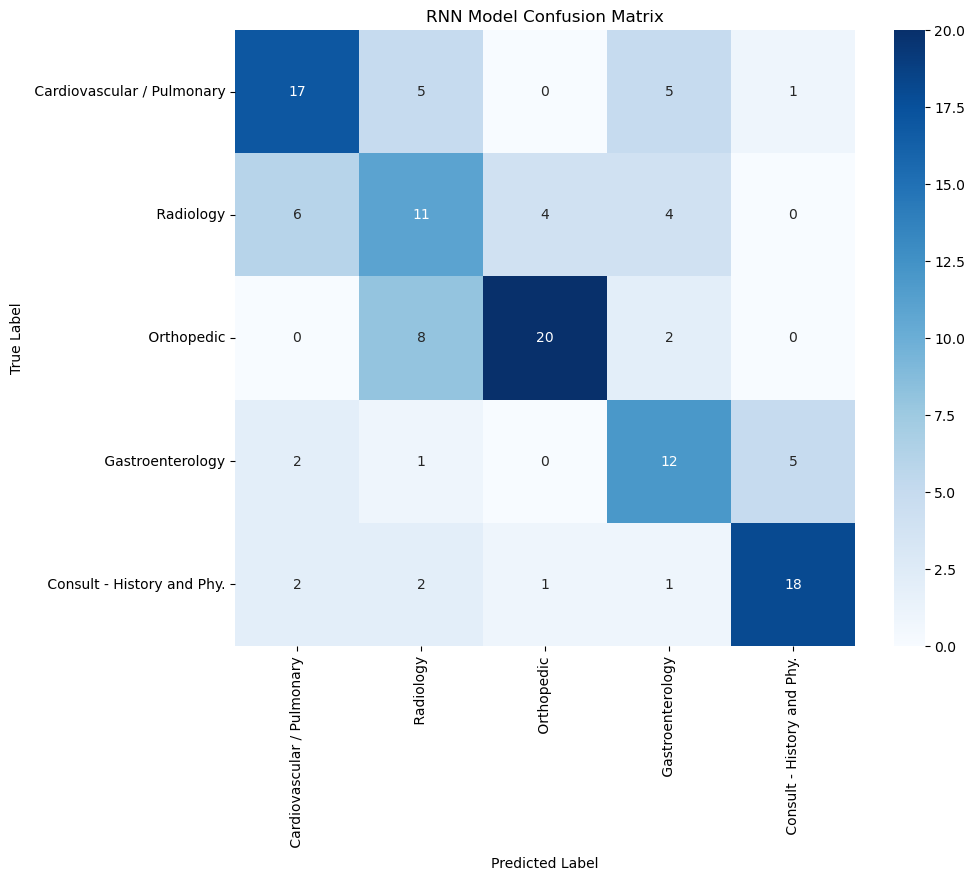

In [19]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)

# Test the model
print(f"Evaluating on test set")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# How well did each area get classified
report = classification_report(y_test, y_pred, target_names=label_names)
print(f"Classification Report")
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', 
    xticklabels=label_names, yticklabels=label_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RNN Model Confusion Matrix')
plt.show()

In [5]:
# Save model

BASE_MODEL_FINAL_DIRECTORY = "./Saved-Models/RNN/base_rnn.keras"

print(f"Saving final model to {BASE_MODEL_FINAL_DIRECTORY}")
model.save(BASE_MODEL_FINAL_DIRECTORY)
print(f"Model saved")

Saving final model to ./Saved-Models/RNN/base_rnn.keras


NameError: name 'model' is not defined

In [6]:
# BUILD RNN WITH ADDITIONAL VOCABULARY

In [7]:
DATA = '../../Data/Specialty-Data/specialty_data.csv'
MAPPINGS = '../../Data/Specialty-Data/specialty_data_label_mappings.json'
FEATURE = 'transcription'

# Constants to configure RNN
VOCAB_SIZE = 10000
# 512 Tokens
MAX_SEQUENCE_LENGTH = 512
VECTOR_SIZE = 300
EPOCHS = 20
BATCH_SIZE = 32

In [8]:
# Retrieve data and build respective train/test/validate datasets

try:
    df = pd.read_csv(DATA)
    with open(MAPPINGS, 'r') as f:
        mappings = json.load(f)
    
    id_to_label = {int(k): v for k, v in mappings['id_to_label'].items()}
    label_names = [id_to_label[i] for i in range(len(id_to_label))]
    NUM_CLASSES = len(label_names)

except:
    print(f"Data not found, make sure to run the specialty_data_preprocessing.ipynb file in its entirety to retrieve the data")

texts = df[FEATURE].values
labels = df['label'].values

# 1 / 10 = 0.1
X_train_val, X_test, y_train_val, y_test = train_test_split(
    texts, labels, test_size=0.1, stratify=labels, random_state=0
)

# 1 / 9 = 0.111
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.111, stratify=y_train_val, random_state=0
)

print(f"Total samples: {len(texts)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of classes: {NUM_CLASSES}")

Total samples: 1263
Training samples: 1009
Validation samples: 127
Test samples: 127
Number of classes: 5


In [ ]:
# Download the vocabulary dataset to use for this next RNN model

URL = "https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.300d.zip"
DATA_DIRECTORY = "../../Data/Specialty-Data"
DOWNLOADED_ZIP = os.path.join(DATA_DIRECTORY, "glove.2024.wikigiga.300d.zip")
GLOVE_PATH = os.path.join(DATA_DIRECTORY, "wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt")

if os.path.exists(GLOVE_PATH):
    print(f"Dataset already exists at {GLOVE_PATH}")
else:
    print(f"Downloading dataset to {DOWNLOADED_ZIP}, this will take a bit, roughly 1.1gb zip download,")

    with requests.get(URL, stream=True) as r:
        r.raise_for_status()
        with open(DOWNLOADED_ZIP, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    print(f"Downloaded to {DOWNLOADED_ZIP}")

    print("-------------------------------------")

    print("Extracting zip, this will take a bit of time to unpack")

    with zipfile.ZipFile(DOWNLOADED_ZIP, "r") as zip_ref:
        zip_ref.extractall(DATA_DIRECTORY)

    print(f"Files extracted to: {DATA_DIRECTORY}")

    os.remove(DOWNLOADED_ZIP)

    print("Zip removed")

Dataset already exists at ../../Data/Specialty-Data\wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt


In [ ]:
# Gonna prebuild vocabulary to try to improve RNN model 

print(f"Prebuild vocabulary with GloVe dataset, this will take a bit.")

vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

vectorize_layer.adapt(X_train)
vocabulary = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embeddings_index = {}
try:
    with open(GLOVE_PATH, encoding='utf8') as f:
        for line in f:
            word, coefs_string = line.split(maxsplit=1)
            coefs = np.fromstring(coefs_string, "f", sep=" ")

            # Many vectors missing 300 dimensionality, ignore those that do not
            if coefs.shape[0] == VECTOR_SIZE:
                embeddings_index[word] = coefs
            else:
                # print(f"Skipping word that has improper dimensionality: {word}") 
                pass
except:
    print(f"GloVe not found, make sure to do the downloading from the previous code block")

print(f"Found {len(embeddings_index)} vectors.")

Prebuild vocabulary with GloVe dataset, this will take a bit


C:\Users\spenc\AppData\Local\Temp\ipykernel_28084\1592011784.py:20: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs_string, "f", sep=" ")


Found 1287614 vectors.


In [11]:
num_tokens = len(vocabulary)
hits = 0
misses = 0

# Create embedding matrix to give the model a solid foundation
embedding_matrix = np.zeros((num_tokens, VECTOR_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words and {misses} misses")

# Look up training vector based on token
embedding_layer = Embedding(
    num_tokens,
    VECTOR_SIZE,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    # False = Lock weights, True = Unlock all weights
    trainable=False,
    name="embedding"
)

# Build RNN with layers here
model = Sequential([
    # Input layer
    tf.keras.Input(shape=(1,), dtype=tf.string),
    # Vectorization layer
    vectorize_layer,
    # Embedding layer
    embedding_layer,
    # Read text from both directions
    Bidirectional(LSTM(64)),
    # Feed forward network to mix features
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Output probabilities for each class
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# End training if validation loss is not decreasing
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

Converted 7966 words and 2034 misses


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 512)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 512, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,195,461 (12.19 MB)

 Trainable params: 195,461 (763.52 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.4073 - loss: 1.4076 - val_accuracy: 0.5276 - val_loss: 1.2355
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.6254 - loss: 1.0477 - val_accuracy: 0.6929 - val_loss: 0.8973
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.7037 - loss: 0.8416 - val_accuracy: 0.7244 - val_loss: 0.7938
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.7463 - loss: 0.7293 - val_accuracy: 0.7323 - val_loss: 0.7257
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.7671 - loss: 0.6265 - val_accuracy: 0.6772 - val_loss: 0.7607
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.7820 - loss: 0.5463 - val_accuracy: 0.6063 - val_loss: 1.1205
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.7721 - loss: 0.6055 - val_accuracy: 0.6929 - val_loss: 0.7913
Evaluating on test set
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6693 - loss: 0.8732
Test Accu

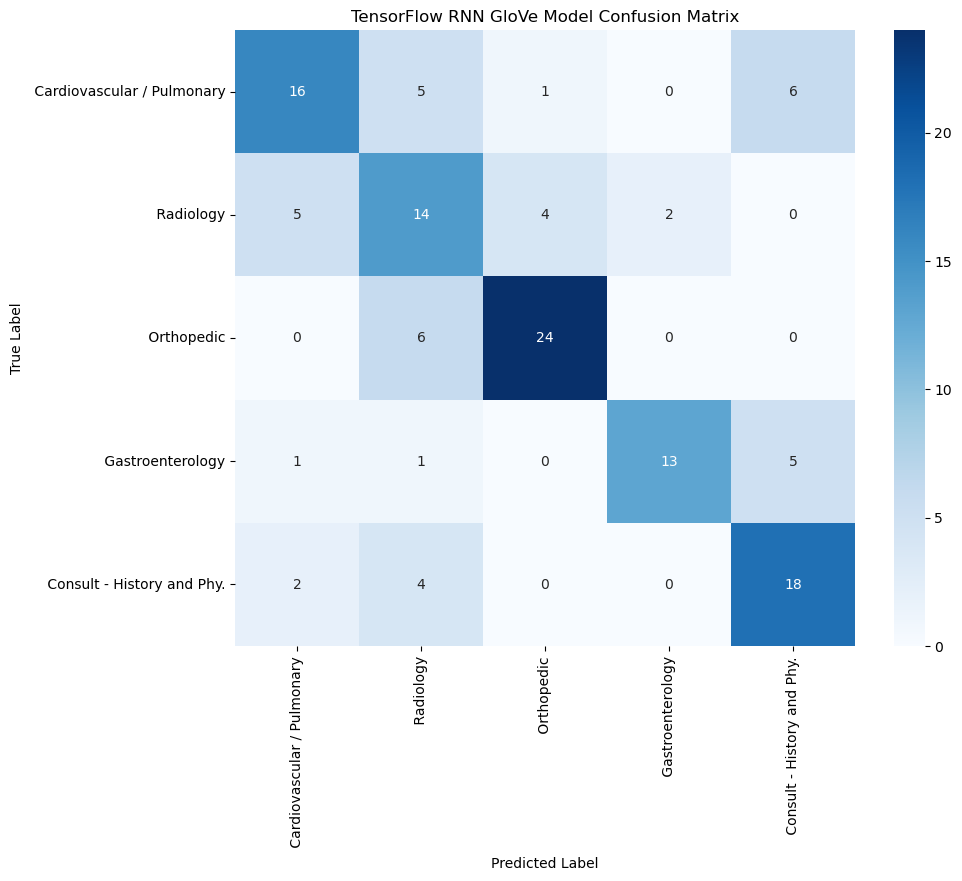

In [12]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)

# Test the model
print(f"Evaluating on test set")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# How well did each area get classified
report = classification_report(y_test, y_pred, target_names=label_names)
print(f"Classification Report")
print(report)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', 
    xticklabels=label_names, yticklabels=label_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('TensorFlow RNN GloVe Model Confusion Matrix')
plt.show()

In [ ]:
# Save model

GLOVE_MODEL_FINAL_DIRECTORY = "./Saved-Models/RNN/glove_rnn.keras"

print(f"Saving final model to {GLOVE_MODEL_FINAL_DIRECTORY}")
model.save(GLOVE_MODEL_FINAL_DIRECTORY)
print(f"Model saved")

# Remove a tmp file made by tensor
if os.path.exists("tmp_trainer"):
    try:
        shutil.rmtree("tmp_trainer")
    except:
        print(f"Failed ot remove tmp_trainer, feel free to delete it if it's still there")